<a href="https://colab.research.google.com/github/beyzassevval/Akbank_DerinOgrenme_BootCamp/blob/main/Brain_MR_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ====================================================================
# Adım 1: Gerekli Kütüphaneleri Yükleme ve Kaggle API Kurulumu
# =================================================

Kaggle API ile kolayca veri seti indirmek için opendatasets kütüphanesini yüklüyoruz.
===================================================
TensorFlow ve Keras'ı yüklüyoruz.
===================================================
Kullanıcıdan Kaggle.json dosyasını yüklemesini istiyoruz
Dosyayı doğru konuma taşıyıp,izinleri ayarlıyoruz.

===================================================

In [1]:

print("Adım 1: Kurulumlar yapılıyor...")
!pip install opendatasets --upgrade --quiet
!pip install tensorflow --quiet

import opendatasets as od
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

print("\nLütfen Kaggle API anahtarınızı (kaggle.json) yükleyin.")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    print("\n'kaggle.json' başarıyla yüklendi.")

    if not os.path.exists('/root/.kaggle'):
        os.makedirs('/root/.kaggle')
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)
else:
    raise ValueError("HATA: Lütfen 'kaggle.json' dosyasını yüklediğinizden emin olun.")

Adım 1: Kurulumlar yapılıyor...

Lütfen Kaggle API anahtarınızı (kaggle.json) yükleyin.


Saving kaggle.json to kaggle.json

'kaggle.json' başarıyla yüklendi.


# =====================================
# Adım 2: Kaggle Veri Setini İndirme
# =====================================

In [2]:
print("Adım 2: Veri seti indiriliyor...")

dataset_url = "https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection"
od.download(dataset_url, data_dir="brain_mri_dataset")

print("Veri seti indirildi.")


Adım 2: Veri seti indiriliyor...
Skipping, found downloaded files in "brain_mri_dataset/brain-mri-images-for-brain-tumor-detection" (use force=True to force download)
Veri seti indirildi.


=================================================

Adım 3:Veri Seti Klasör yapısını ve sınıf başına kaç görsel olduğunu gösterelim

=================================================


In [20]:
import os

data_path = "/content/brain_mri_dataset/brain-mri-images-for-brain-tumor-detection"

for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:  # İlk 5 dosyayı göster
        print(f"{subindent}{f}")
    if len(files) > 5:
        print(f"{subindent}... ({len(files)} dosya)")

print("\nSınıf başına dosya sayısı:")
for class_name in os.listdir(os.path.join(data_path, '/content/brain_mri_dataset/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset')):
    class_dir = os.path.join(data_path, '/content/brain_mri_dataset/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset', class_name)
    if os.path.isdir(class_dir):
        count = len(os.listdir(class_dir))
        print(f"{class_name}: {count} adet")


brain-mri-images-for-brain-tumor-detection/
    no/
        33 no.jpg
        no 9.png
        No17.jpg
        11 no.jpg
        no 3.jpg
        ... (98 dosya)
    yes/
        Y163.JPG
        Y46.jpg
        Y107.jpg
        Y23.JPG
        Y59.JPG
        ... (155 dosya)
    brain_tumor_dataset/
        no/
            33 no.jpg
            no 9.png
            No17.jpg
            11 no.jpg
            no 3.jpg
            ... (98 dosya)
        yes/
            Y163.JPG
            Y46.jpg
            Y107.jpg
            Y23.JPG
            Y59.JPG
            ... (155 dosya)

Sınıf başına dosya sayısı:
no: 98 adet
yes: 155 adet


=================================================

Adım 3:Veri yolları ve klasörler

=================================================

Önceki denemelerimde Veri sızıntısı olduğu için,

veri sızıntılarını düzeltme kodu ekledim.

Daha sonra verileri yükleyip doğru klasörlere böldüm


In [21]:
import shutil
import os
from sklearn.model_selection import train_test_split

base_dir = "/content/brain_mri_dataset/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "yes"), exist_ok=True)
    os.makedirs(os.path.join(d, "no"), exist_ok=True)

yes_images = os.listdir(os.path.join(base_dir, "yes"))
no_images = os.listdir(os.path.join(base_dir, "no"))

yes_train, yes_temp = train_test_split(yes_images, test_size=0.3, random_state=42)
yes_val, yes_test = train_test_split(yes_temp, test_size=0.5, random_state=42)
no_train, no_temp = train_test_split(no_images, test_size=0.3, random_state=42)
no_val, no_test = train_test_split(no_temp, test_size=0.5, random_state=42)

def fix_data_leakage():
    """Veri sızıntısını düzelt"""
    import shutil
    import os

    if os.path.exists("data"):
        shutil.rmtree("data")

    base_dir = "/content/brain_mri_dataset/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
    train_dir = "data/train"
    val_dir = "data/val"
    test_dir = "data/test"

    for d in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(d, "yes"), exist_ok=True)
        os.makedirs(os.path.join(d, "no"), exist_ok=True)

    yes_images = os.listdir(os.path.join(base_dir, "yes"))
    no_images = os.listdir(os.path.join(base_dir, "no"))

    yes_train, yes_temp = train_test_split(yes_images, test_size=0.3, random_state=42)
    yes_val, yes_test = train_test_split(yes_temp, test_size=0.5, random_state=42)

    no_train, no_temp = train_test_split(no_images, test_size=0.3, random_state=42)
    no_val, no_test = train_test_split(no_temp, test_size=0.5, random_state=42)

    def safe_copy_images(img_list, src_folder, dest_folder):
        for img in img_list:
            src_path = os.path.join(src_folder, img)
            dest_path = os.path.join(dest_folder, img)
            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)

    safe_copy_images(yes_train, os.path.join(base_dir, "yes"), os.path.join(train_dir, "yes"))
    safe_copy_images(yes_val, os.path.join(base_dir, "yes"), os.path.join(val_dir, "yes"))
    safe_copy_images(yes_test, os.path.join(base_dir, "yes"), os.path.join(test_dir, "yes"))

    safe_copy_images(no_train, os.path.join(base_dir, "no"), os.path.join(train_dir, "no"))
    safe_copy_images(no_val, os.path.join(base_dir, "no"), os.path.join(val_dir, "no"))
    safe_copy_images(no_test, os.path.join(base_dir, "no"), os.path.join(test_dir, "no"))

    print("✅ Veri sızıntısı düzeltildi!")

fix_data_leakage()

✅ Veri sızıntısı düzeltildi!


````markdown
=================================================

Adım 4:Veri Ön İşleme ve Augmentation

=================================================
```python
# Görüntü boyutları ve batch ayarları
IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation sadece eğitim verisi için uygulanır
# Validation ve test verileri sadece normalize edilir

In [22]:
IMG_SIZE = 224
BATCH_SIZE = 32
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


# kesin eşitlik kontrolü

In [23]:
print("train:", train_gen.class_indices)
print("val:  ", val_gen.class_indices)
print("test: ", test_gen.class_indices)
assert train_gen.class_indices == val_gen.class_indices == test_gen.class_indices, "class_indices farklı!"


train: {'no': 0, 'yes': 1}
val:   {'no': 0, 'yes': 1}
test:  {'no': 0, 'yes': 1}


Ayrıca klasörleri saydım, kontrol amaçlı

In [24]:
from collections import Counter
print("Train counts:", Counter(train_gen.classes))
print("Val counts:  ", Counter(val_gen.classes))
print("Test counts: ", Counter(test_gen.classes))

# Ayrıca klasörleri say:
import os
for split in ["data/train","data/val","data/test"]:
    print(split, {d: len(os.listdir(os.path.join(split,d))) for d in os.listdir(split)})


Train counts: Counter({np.int32(1): 108, np.int32(0): 68})
Val counts:   Counter({np.int32(1): 23, np.int32(0): 15})
Test counts:  Counter({np.int32(1): 24, np.int32(0): 15})
data/train {'no': 68, 'yes': 108}
data/val {'no': 15, 'yes': 23}
data/test {'no': 15, 'yes': 24}


````markdown
=================================================

Adım 5:Veri Generator Kontrol Fonksiyonu

=================================================
Bu fonksiyon veri generator'larının doğru çalıştığını kontrol eder.

## Ana İşlevler
- Data augmentation ayarlarını test etme
- Veri şekillerini ve sınıf dağılımını kontrol etme
- Batch işleme sürecini doğrulama

```python
# Kullanım
train_gen, val_gen, test_gen = check_data_generators()

In [25]:
def check_data_generators():
    """Data generator'ları kontrol et"""
    print("🔍 DATA GENERATOR KONTROLÜ:")

    # Generator'ları yeniden oluştur
    from tensorflow.keras.applications.efficientnet import preprocess_input

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8,1.2]
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


    # Batch size'ı küçült (debug için)
    BATCH_SIZE = 16
    IMG_SIZE = 224

    train_gen = train_datagen.flow_from_directory(
        "data/train",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )

    val_gen = val_datagen.flow_from_directory(
        "data/val",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    test_gen = test_datagen.flow_from_directory(
        "data/test",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )

    print(f"✅ Train sınıfları: {train_gen.class_indices}")
    print(f"✅ Validation sınıfları: {val_gen.class_indices}")
    print(f"✅ Train örnek sayısı: {train_gen.samples}")
    print(f"✅ Validation örnek sayısı: {val_gen.samples}")

    # Sınıf isimlerini kaydet
    class_names = list(train_gen.class_indices.keys())
    print("Sınıf isimleri:", class_names)  # ['no', 'yes']


    # Bir batch göster
    x_batch, y_batch = next(train_gen)
    print(f"✅ Batch shape: {x_batch.shape}")
    print(f"✅ Batch labels: {y_batch[:10]}")

    return train_gen, val_gen, test_gen

# Generator'ları kontrol et
train_gen, val_gen, test_gen = check_data_generators()

🔍 DATA GENERATOR KONTROLÜ:
Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
✅ Train sınıfları: {'no': 0, 'yes': 1}
✅ Validation sınıfları: {'no': 0, 'yes': 1}
✅ Train örnek sayısı: 176
✅ Validation örnek sayısı: 38
Sınıf isimleri: ['no', 'yes']
✅ Batch shape: (16, 224, 224, 3)
✅ Batch labels: [1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]


=================================================

Adım 6: Model - WfficientNetB0 + fine-tuning

=================================================

## Ana İşlevler
- fıne tuning i açık tuttuk
- Güncel modellerden olan EfficientNetB0 ile modeli oluşturduk
- CallBacks ekledim

In [26]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=2)


=================================================

Adım 7: Model Eğitimi

=================================================

Ana İşlevlev
Sınıf ağırlıklarını hesaplayarak

20 Epochs'luk bir eğitim yaptım


In [27]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_gen.reset()
val_gen.reset()
val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))

y_train = train_gen.classes

from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {int(classes[i]): float(cw[i]) for i in range(len(classes))}
print("class_weight_dict:", class_weight_dict)

class_weight_dict = dict(enumerate(cw))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("\nAdım 7: Model Eğitimi yapılıyor...")

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict
)

print("Model eğitimi tamamlandı.")

class_weight_dict: {0: 1.2941176470588236, 1: 0.8148148148148148}

Adım 7: Model Eğitimi yapılıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.5243 - loss: 1.1881 - precision: 0.6109 - recall: 0.5473 - val_accuracy: 0.5625 - val_loss: 0.6960 - val_precision: 0.8000 - val_recall: 0.2353 - learning_rate: 1.0000e-04
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.6437 - loss: 0.7300 - precision: 0.7942 - recall: 0.6165 - val_accuracy: 0.5625 - val_loss: 0.6754 - val_precision: 0.8000 - val_recall: 0.2353 - learning_rate: 1.0000e-04
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.6775 - loss: 0.7011 - precision: 0.7521 - recall: 0.6922 - val_accuracy: 0.5625 - val_loss: 0.6465 - val_precision: 0.8000 - val_recall: 0.2353 - learning_rate: 1.0000e-04
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.7381 - loss: 0.5728 - precision: 0.8486 - recall: 0.6794 - val_accuracy: 0.6250 - val_loss: 0.6071 - val_precision: 1.0000 - val_recall: 0.2941 - learning_rate: 1.0000e-04
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - acc

# ======================================================================
# Adım 8: Gelişmiş Metrikleri Hesaplama ve Yazdırma
# ======================================================================

## Confusion Matrix , F1 Score , Loss function gibi
## Model değerlendirilmesini yapacağım grafikleri oluşturdum

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 842ms/step

MODEL DEĞERLENDİRME SONUÇLARI (Doğrulama Veri Seti)
Sınıflandırma Raporu (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

          no       0.81      0.87      0.84        15
         yes       0.91      0.87      0.89        23

    accuracy                           0.87        38
   macro avg       0.86      0.87      0.86        38
weighted avg       0.87      0.87      0.87        38

----------------------------------------------------------------------


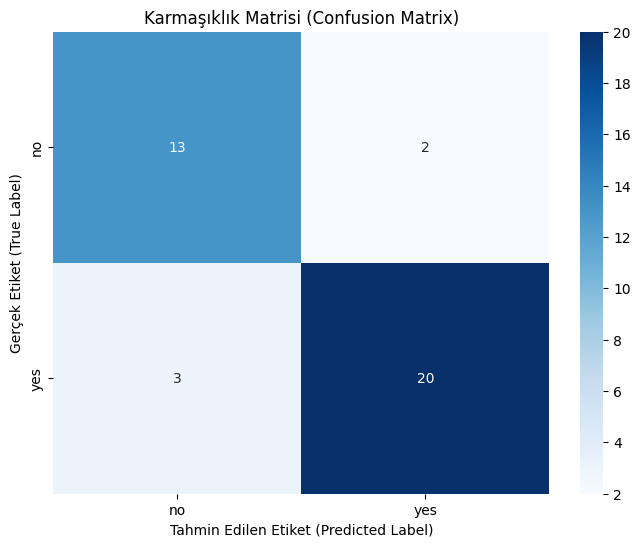

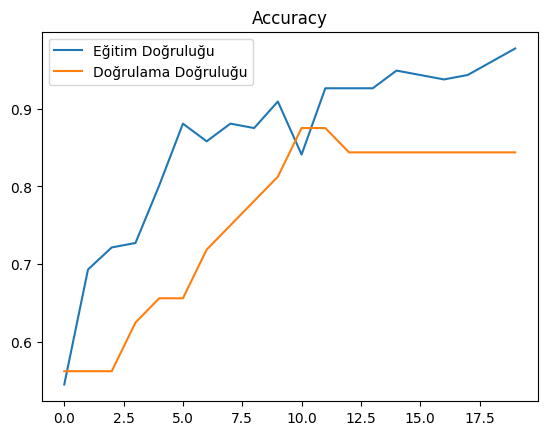

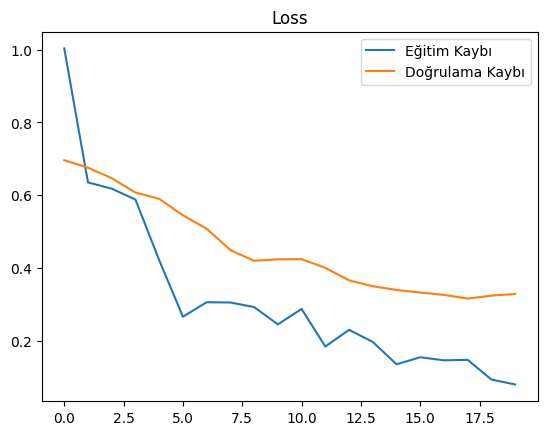

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

val_gen.reset()

val_steps = val_gen.samples // val_gen.batch_size + (val_gen.samples % val_gen.batch_size > 0)

predictions = model.predict(val_gen, steps=val_steps)

y_true = val_gen.classes


y_pred = np.round(predictions).flatten()

class_names = list(val_gen.class_indices.keys())

print("\n" + "="*70)
print("MODEL DEĞERLENDİRME SONUÇLARI (Doğrulama Veri Seti)")
print("="*70)


print("Sınıflandırma Raporu (Precision, Recall, F1-Score):")
print(classification_report(y_true, y_pred, target_names=class_names))

print("-" * 70)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Karmaşıklık Matrisi (Confusion Matrix)")
plt.ylabel('Gerçek Etiket (True Label)')
plt.xlabel('Tahmin Edilen Etiket (Predicted Label)')
plt.show()

print("="*70)

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.title("Loss")
plt.show()

=================================================================
Adım 9: Kullanıcudan MR Görseli alıp Tahmin Yapmak
=================================================================

uploaded=files.upload()
img=Image.open(img_path)
# Buton çıkarıp kullanıcıdan görsel yüklemesini sağlar

#predict ile tahmin yapmasını sağladım


Saving WhatsApp Image 2025-09-26 at 14.20.40.jpeg to WhatsApp Image 2025-09-26 at 14.20.40 (1).jpeg
Seçilen dosya: WhatsApp Image 2025-09-26 at 14.20.40 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


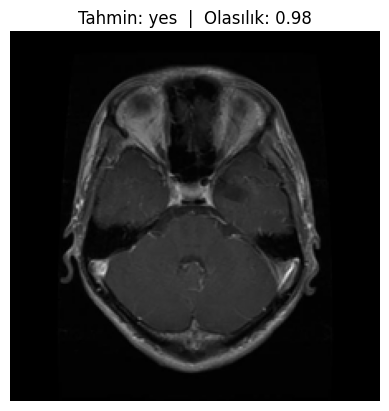

In [35]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image

# --- Kullanıcıdan görsel yükleme ---
uploaded = files.upload()  # Colab butonu çıkar, görsel seçilir
for fn in uploaded.keys():
    img_path = fn
    print("Seçilen dosya:", img_path)

    # Görseli aç ve modele uygun boyutlandır
    img = Image.open(img_path).convert("RGB").resize((224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Tahmin
    preds = model.predict(img_array)
    y_pred = (preds > 0.5).astype(int).ravel()[0]

    # Sınıf etiketini al
    idx_to_class = {v:k for k,v in train_gen.class_indices.items()}
    class_label = idx_to_class[y_pred]

    # Görseli tahminle birlikte göster
    plt.imshow(img)
    plt.title(f"Tahmin: {class_label}  |  Olasılık: {preds[0][0]:.2f}")
    plt.axis("off")
    plt.show()
